In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import visualization
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import sys
import os
import glob

import utils

In [10]:
D_PayneDir = utils.D_PayneDir
Standards_Dir = D_PayneDir+'other_data/standards/'

In [32]:
def find_obj_in_sample(Obj_RA_Dec, Sample_RA_Dec, sep=0.0001*u.deg, nsteps=10, verbose=True):
    coord = Obj_RA_Dec
    for i in range(nsteps):
        match_ind = np.argwhere(Sample_RA_Dec.separation(coord) < sep)
        if len(match_ind) < 1:
            sep = sep * 1.1
        elif len(match_ind) > 1:
            sep = sep * 0.9
        elif len(match_ind) == 1:
            continue
    if len(match_ind) < 1:
        if verbose:
            print('No Matches within %.2e degrees' % sep.value)
        return()
    elif len(match_ind) > 1:
        if verbose:
            print('Multiple Matches within %.2e' % sep.value)
        return(match_ind)
    else:
        if verbose:
            print('MATCH FOUND!')
        match_ind = match_ind[0,0]
        match_sep = Sample_RA_Dec[match_ind].separation(coord).deg
        return(match_ind, match_sep)
    
def restore_observed_spectra(target, method):
    SpectraFile = target + '_' + method + '.npz'
    temp = np.load(SpectraDir + SpectraFile)
    obj = temp['obj']
    norm_spec = temp['norm_spec']
    spectral_err = temp['spec_err']
    dv = temp['dv']
    Obs_RA_Dec = SkyCoord(temp['RA_Dec'])
    temp.close()
    return(obj, norm_spec, spectral_err, dv, Obs_RA_Dec)

def restore_APOGEE_standards():
    temp = np.genfromtxt(Standards_Dir + 'APOGEEPayne_standards.txt', dtype=str)
    APOGEE_ID = temp[:,1]
    APOGEE_RA_Dec = SkyCoord([temp[i,1]+' '+temp[i,2] for i in range(len(temp))], unit=u.deg)
    Teff = temp[:,3]
    Logg = temp[:,4]
    MgH = temp[:,9]
    FeH = temp[:,18]
    Quality = temp[:,-1]
    return(APOGEE_ID, APOGEE_RA_Dec, Teff, Logg, MgH, FeH, Quality)

def restore_Kirby2010_standards(res='medium'):
    fname = Standards_Dir + 'Kirby2010_standards.txt'
    with open(fname) as f:
        temp = f.readlines()
    temp = temp[49:]
    temp = [x.strip() for x in temp]
    f.close()
    
    System = np.array([x[:15].replace(" ","") for x in temp])
    Name = np.array([x[15:29].replace(" ","") for x in temp])
    Ref = np.array([x[29:55].replace(" ","") for x in temp])
    RA = [x[55:66].strip().replace(" ",":") for x in temp]
    Dec = [x[66:78].strip().replace(" ",":") for x in temp]
    kirby_RA_Dec = SkyCoord(RA, Dec, unit=(u.hourangle,u.deg))
    
    if res == 'high':
        Teff = np.array([x[78:83].strip().replace(" ","") for x in temp],dtype=float)
        logg = np.array([x[83:88].strip().replace(" ","") for x in temp],dtype=float)
        Fe_H = np.array([x[93:99].strip().replace(" ","") for x in temp],dtype=float)
        Mg_Fe_temp = [x[104:110].strip().replace(" ","") for x in temp]
        Mg_Fe = np.array(['100' if x=='' else x for x in Mg_Fe_temp],dtype=float)
        Mg_Fe[Mg_Fe == 100] = np.nan
        Si_Fe_temp = [x[115:121].strip().replace(" ","") for x in temp]
        Si_Fe = np.array(['100' if x=='' else x for x in Si_Fe_temp],dtype=float)
        Si_Fe[Si_Fe == 100] = np.nan
        Ca_Fe_temp = [x[126:132].strip().replace(" ","") for x in temp]
        Ca_Fe = np.array(['100' if x=='' else x for x in Ca_Fe_temp],dtype=float)
        Ca_Fe[Ca_Fe == 100] = np.nan
        Ti_Fe_temp = [x[137:143].strip().replace(" ","") for x in temp]
        Ti_Fe = np.array(['100' if x=='' else x for x in Ti_Fe_temp],dtype=float)
        Ti_Fe[Ti_Fe == 100] = np.nan
    
    if res == 'medium':
        Teff = np.array([x[148:153].strip().replace(" ","") for x in temp],dtype=float)
        logg = np.array([x[153:158].strip().replace(" ","") for x in temp],dtype=float)
        Fe_H = np.array([x[163:169].strip().replace(" ","") for x in temp],dtype=float)
        Mg_Fe_temp = [x[174:180].strip().replace(" ","") for x in temp]
        Mg_Fe = np.array(['100' if x=='' else x for x in Mg_Fe_temp],dtype=float)
        Mg_Fe[Mg_Fe == 100] = np.nan
        Si_Fe_temp = [x[185:191].strip().replace(" ","") for x in temp]
        Si_Fe = np.array(['100' if x=='' else x for x in Si_Fe_temp],dtype=float)
        Si_Fe[Si_Fe == 100] = np.nan
        Ca_Fe_temp = [x[196:202].strip().replace(" ","") for x in temp]
        Ca_Fe = np.array(['100' if x=='' else x for x in Ca_Fe_temp],dtype=float)
        Ca_Fe[Ca_Fe == 100] = np.nan
        Ti_Fe_temp = [x[207:213].strip().replace(" ","") for x in temp]
        Ti_Fe = np.array(['100' if x=='' else x for x in Ti_Fe_temp],dtype=float)
        Ti_Fe[Ti_Fe == 100] = np.nan
        
    return(kirby_RA_Dec, System, Name, Teff, logg, Fe_H, Mg_Fe, Si_Fe, Ca_Fe, Ti_Fe)


def restore_Kirby2008_standards():
    fname = Standards_Dir + 'Kirby2008_standards.fit'
    hdul = fits.open(fname)
    
    RA = hdul[1].data['_RAJ2000']
    Dec = hdul[1].data['_DEJ2000']
    RA_Dec = SkyCoord(RA, Dec, unit=(u.deg,u.deg))
    cluster = hdul[1].data['Cluster']
    Teff = hdul[1].data['Teff']
    logg = hdul[1].data['log_g_']    
    FeH_M = hdul[1].data['__Fe_H_M']
    alphaFe_M = hdul[1].data['__a_Fe_M']
    FeH_H = hdul[1].data['__Fe_H_H']
    alphaFe_H = hdul[1].data['__a_Fe_H']
    
    return(RA_Dec, cluster, Teff, logg, FeH_M, alphaFe_M, FeH_H, alphaFe_H)

# Restore Observations

In [35]:
SpectraDir = D_PayneDir + 'spectra/obs_spectra/'
targets = ['m2', 'm13', 'm15','m71', 'ngc2419', 'ngc7006',
           'pegdig', 'pegdig24', 'pegdig26', 'wlm']
method = 'Horne'
verbose = False

# Restore APOGEE standards
APOGEE_ID, APOGEE_RA_Dec, APOGEE_Teff, APOGEE_logg,\
    APOGEE_MgH, APOGEE_FeH, APOGEE_Quality = restore_APOGEE_standards()
# Restore Kirby+ 2010 standards 
kirby_RA_Dec, kirby_cluster, kirby_Teff, kirby_logg,\
    kirby_FeH_M, kirby_alphaFe_M, kirby_FeH_H, kirby_alphaFe_H\
    = restore_Kirby2008_standards()

# Check APOGEE Payne Sample



APOGEE SUMMARY: m2
No Matches :(


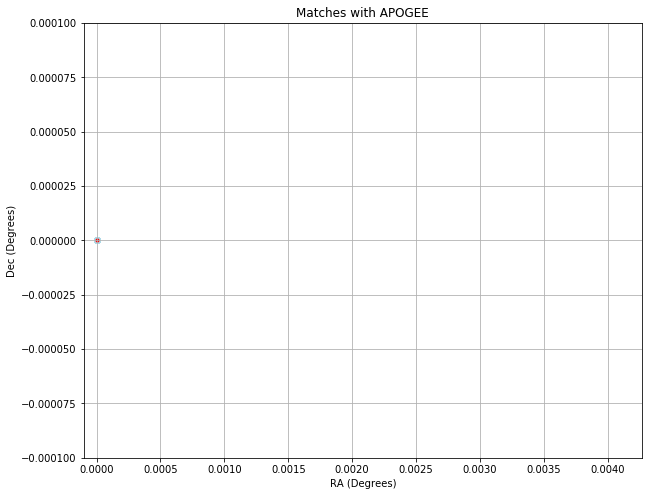



APOGEE SUMMARY: m13
No Matches :(


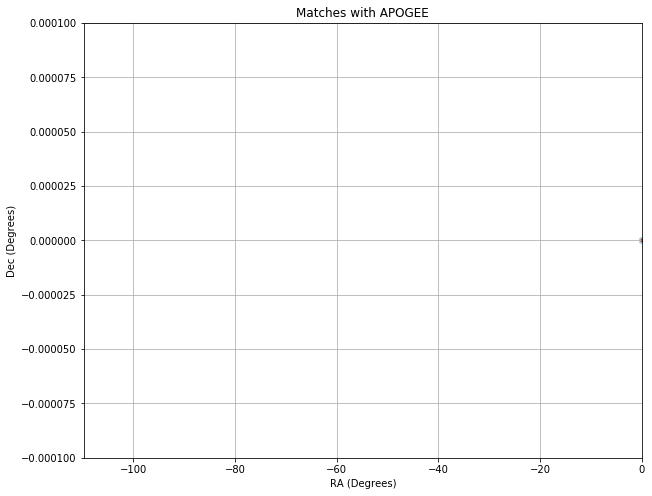



APOGEE SUMMARY: m15
2 Matches found
Index: 210253
Object: #008.0010337
DEIMOS Star Coordinate
RA: -37.505208 deg
Dec: 12.291389 deg
APOGEE Star Coordinate
RA: -37.505210 deg
Dec: 12.291350 deg
Teff = 5663.6 K
Logg = 4.30
[Fe/H] = 0.33

[Mg/H] = 0.23
Index: 210111
Object: #020.0010068
DEIMOS Star Coordinate
RA: -37.634292 deg
Dec: 12.255278 deg
APOGEE Star Coordinate
RA: -37.634370 deg
Dec: 12.255250 deg
Teff = 5650.5 K
Logg = 3.64
[Fe/H] = -1.26

[Mg/H] = -0.36


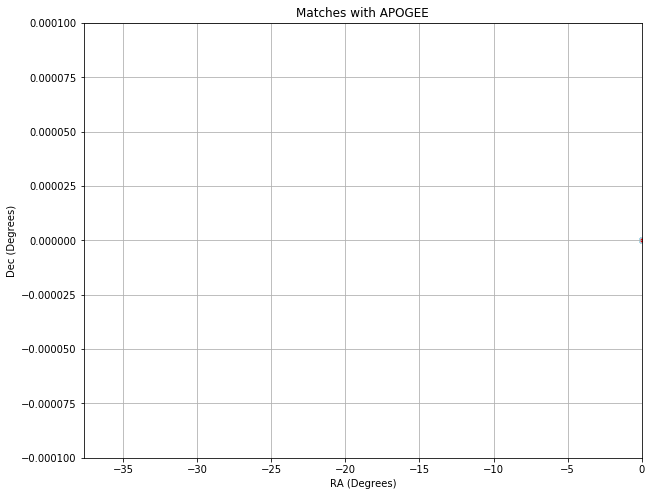



APOGEE SUMMARY: m71
1 Matches found
Index: 197178
Object: #006.0000191
DEIMOS Star Coordinate
RA: -61.620792 deg
Dec: 18.559000 deg
APOGEE Star Coordinate
RA: -61.620860 deg
Dec: 18.559000 deg
Teff = 4295.2 K
Logg = 2.30
[Fe/H] = -0.06

[Mg/H] = 0.06


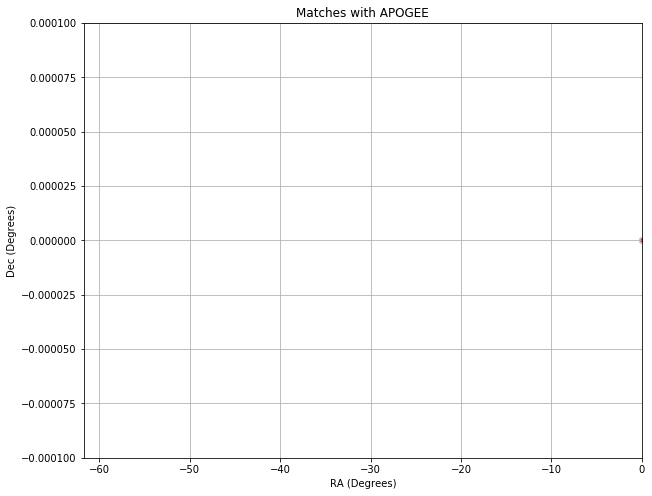



APOGEE SUMMARY: ngc2419
No Matches :(


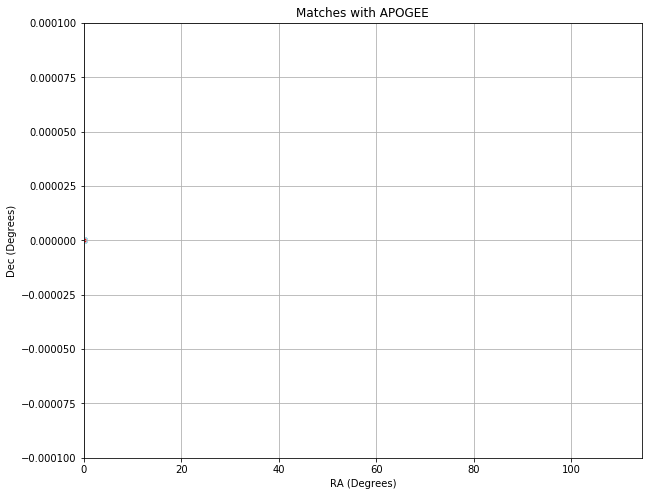



APOGEE SUMMARY: ngc7006
No Matches :(


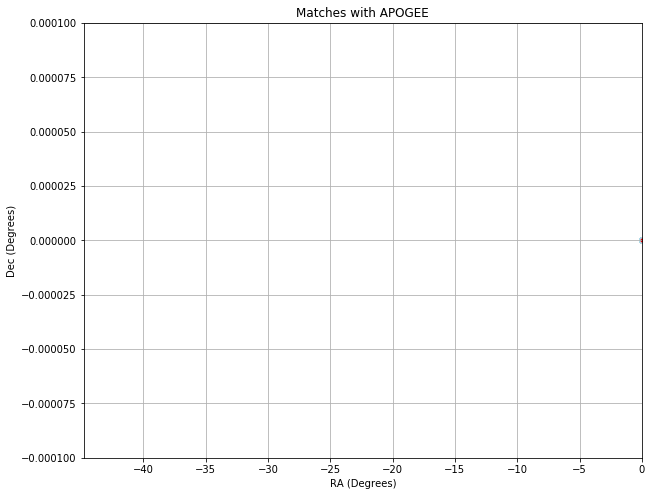



APOGEE SUMMARY: pegdig
No Matches :(


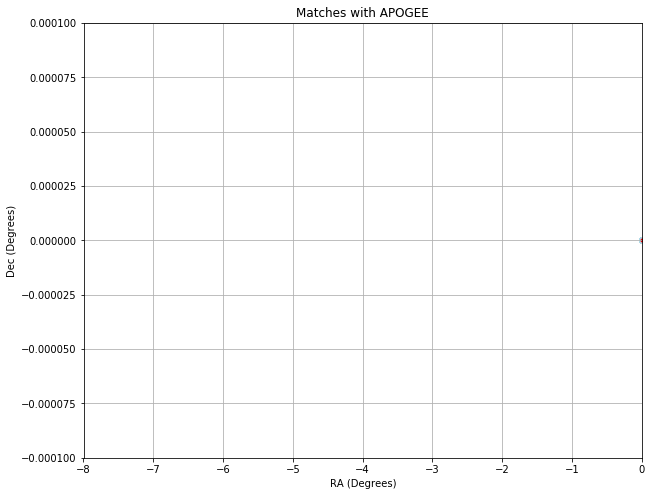

In [ ]:
for target in targets:
    # Restore Observed Spectra
    obj, norm_spec, spectral_err, dv, Obs_RA_Dec = restore_observed_spectra(target, method)
        
    DEIMOS_ind = []
    APOGEE_ind = []
        
    for i in range(len(Obs_RA_Dec)):
        coord = Obs_RA_Dec[i]
        if any(char.isalpha() for char in obj[i]):
            if verbose:
                print('Skipping Serendip')
                print('')
            continue
        if verbose:
            print('Object #%s' % obj[i][4:])
            print('RA: %f' % coord.ra.deg)
            print('Dec: %f' % coord.dec.deg)
        try:
            match_ind, match_sep = find_obj_in_sample(Obj_RA_Dec=coord,
                                                     Sample_RA_Dec=APOGEE_RA_Dec,
                                                     verbose=verbose)
            APOGEE_ind.append(match_ind)
            if verbose:
                print('APOGEE ID: %i' % APOGEE_ID[match_ind])
                print('APOGEE Quality: %s' % Quality[match_ind])
                print('Separated by %.2e degrees' % match_sep)
                print('')
            DEIMOS_ind.append(i)
        except ValueError:
            if verbose:
                print('')
    
    print('\n\nAPOGEE SUMMARY: %s' % target)
    if len(APOGEE_ind)==0:
        print('No Matches :(')
    else:
        print('%i Matches found' % len(APOGEE_ind))
    for i in range(len(APOGEE_ind)):
        print('Index: %i' % APOGEE_ind[i])
        print('Object: #%s' % obj[DEIMOS_ind[i]])
        print('DEIMOS Star Coordinate')
        print('RA: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].ra.wrap_at(180 * u.deg).deg)
        print('Dec: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].dec.wrap_at(180 * u.deg).deg)
        print('APOGEE Star Coordinate')
        print('RA: %f deg' % APOGEE_RA_Dec[APOGEE_ind[i]].ra.wrap_at(180 * u.deg).deg)
        print('Dec: %f deg' % APOGEE_RA_Dec[APOGEE_ind[i]].dec.wrap_at(180 * u.deg).deg)
        print('Teff = %s K' % APOGEE_Teff[APOGEE_ind[i]])
        print('Logg = %s' % APOGEE_logg[APOGEE_ind[i]])
        print('[Fe/H] = %s\n' % APOGEE_FeH[APOGEE_ind[i]])
        print('[Mg/H] = %s' % APOGEE_MgH[APOGEE_ind[i]])

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    apogee_ra = APOGEE_RA_Dec.ra.wrap_at(180 * u.deg).deg
    
    obs_ra  = Obs_RA_Dec.ra.wrap_at(180 * u.deg).deg
    min_ra, max_ra = [np.min(obs_ra),np.max(obs_ra)]
    min_dec, max_dec = [np.min(Obs_RA_Dec.dec.deg), np.min(Obs_RA_Dec.dec.deg)]
    
    ax.scatter(obs_ra, Obs_RA_Dec.dec.deg, marker='o',c='lightblue', label='This Work')
    ax.scatter(obs_ra[DEIMOS_ind], Obs_RA_Dec.dec.deg[DEIMOS_ind], marker='o',c='blue', label='Match')
    ax.scatter(apogee_ra, APOGEE_RA_Dec.dec.deg, marker='.',c='r', label='APOGEE')
    
    plt.grid(True)
    plt.xlim(min_ra - 0.0001, max_ra + 0.0001)
    plt.ylim(min_dec - 0.0001, max_dec + 0.0001)
    plt.xlabel('RA (Degrees)')
    plt.ylabel('Dec (Degrees)')
    plt.title('Matches with APOGEE')
    plt.show()

# Check Kirby 2008 GC's

In [ ]:
for target in targets:
    # Restore observed spectra
    obj, norm_spec, spectral_err, dv, Obs_RA_Dec = restore_observed_spectra(target, method)
    
    DEIMOS_ind = []
    kirby_ind = []
        
    for i in range(len(Obs_RA_Dec)):
        coord = Obs_RA_Dec[i]
        if any(char.isalpha() for char in obj[i]):
            if verbose:
                print('Skipping Serendip')
                print('')
            continue
        if verbose:
            print('Object #%s' % obj[i][4:])
            print('RA: %f' % coord.ra.deg)
            print('Dec: %f' % coord.dec.deg)
        try:
            match_ind, match_sep = find_obj_in_sample(Obj_RA_Dec=coord,
                                                     Sample_RA_Dec=kirby_RA_Dec,
                                                     verbose=verbose)
            kirby_ind.append(match_ind)
            if verbose:
                print('Name: %i' % Name[match_ind])
                print('Separated by %.2e degrees' % match_sep)
                print('')
            DEIMOS_ind.append(i)
        except ValueError:
            if verbose:
                print('')
    
    print('\n\nKirby SUMMARY: %s' % target)
    if len(kirby_ind)==0:
        print('No Matches :(')
    else:
        print('%i Matches found' % len(kirby_ind))
        for i in range(len(kirby_ind)):
            print('Index: %i' % DEIMOS_ind[i])
            print('Object: #%s' % obj[DEIMOS_ind[i]])
            print('DEIMOS Star Coordinate')
            print('RA: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].ra.wrap_at(180 * u.deg).deg)
            print('Dec: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].dec.wrap_at(180 * u.deg).deg)
            print('kirby 2008+ Star Coordinate')
            print('RA: %f deg' % kirby_RA_Dec[kirby_ind[i]].ra.wrap_at(180 * u.deg).deg)
            print('Dec: %f deg' % kirby_RA_Dec[kirby_ind[i]].dec.wrap_at(180 * u.deg).deg)
            print('Teff = %s K' % kirby_Teff[kirby_ind[i]])
            print('Logg = %s' % kirby_logg[kirby_ind[i]])
            print('[Fe/H]_M = %s\n' % kirby_FeH_M[kirby_ind[i]])
            print('[alpha/H]_M = %s' % kirby_alphaFe_M[kirby_ind[i]])
            print('[Fe/H]_H = %s\n' % kirby_FeH_H[kirby_ind[i]])
            print('[alpha/H]_H = %s' % kirby_alphaFe_H[kirby_ind[i]])

In [48]:
fname = D_PayneDir + 'other_data/standards/Kirby_2010_standards.txt'
with open(fname) as f:
    temp = f.readlines()
temp = temp[49:]
temp = [x.strip() for x in temp]
f.close()

System = np.array([x[:15].replace(" ","") for x in temp])
Name = np.array([x[15:29].replace(" ","") for x in temp])
Ref = np.array([x[29:55].replace(" ","") for x in temp])
RA = [x[55:66].strip().replace(" ",":") for x in temp]
Dec = [x[66:78].strip().replace(" ",":") for x in temp]
kirby_RA_Dec = SkyCoord(RA, Dec, unit=(u.hourangle,u.deg))

TeffH = np.array([x[78:83].strip().replace(" ","") for x in temp],dtype=float)
loggH = np.array([x[83:88].strip().replace(" ","") for x in temp],dtype=float)
Fe_HH = np.array([x[93:99].strip().replace(" ","") for x in temp],dtype=float)
Mg_FeH_temp = [x[104:110].strip().replace(" ","") for x in temp]
Mg_FeH = np.array(['100' if x=='' else x for x in Mg_FeH_temp],dtype=float)
Mg_FeH[Mg_FeH == 100] = np.nan
Si_FeH_temp = [x[115:121].strip().replace(" ","") for x in temp]
Si_FeH = np.array(['100' if x=='' else x for x in Si_FeH_temp],dtype=float)
Si_FeH[Si_FeH == 100] = np.nan
Ca_FeH_temp = [x[126:132].strip().replace(" ","") for x in temp]
Ca_FeH = np.array(['100' if x=='' else x for x in Ca_FeH_temp],dtype=float)
Ca_FeH[Ca_FeH == 100] = np.nan
Ti_FeH_temp = [x[137:143].strip().replace(" ","") for x in temp]
Ti_FeH = np.array(['100' if x=='' else x for x in Ti_FeH_temp],dtype=float)
Ti_FeH[Ti_FeH == 100] = np.nan

TeffM = np.array([x[148:153].strip().replace(" ","") for x in temp],dtype=float)
loggM = np.array([x[153:158].strip().replace(" ","") for x in temp],dtype=float)
Fe_HM = np.array([x[163:169].strip().replace(" ","") for x in temp],dtype=float)
Mg_FeM_temp = [x[174:180].strip().replace(" ","") for x in temp]
Mg_FeM = np.array(['100' if x=='' else x for x in Mg_FeM_temp],dtype=float)
Mg_FeM[Mg_FeM == 100] = np.nan
Si_FeM_temp = [x[185:191].strip().replace(" ","") for x in temp]
Si_FeM = np.array(['100' if x=='' else x for x in Si_FeM_temp],dtype=float)
Si_FeM[Si_FeM == 100] = np.nan
Ca_FeM_temp = [x[196:202].strip().replace(" ","") for x in temp]
Ca_FeM = np.array(['100' if x=='' else x for x in Ca_FeM_temp],dtype=float)
Ca_FeM[Ca_FeM == 100] = np.nan
Ti_FeM_temp = [x[207:213].strip().replace(" ","") for x in temp]
Ti_FeM = np.array(['100' if x=='' else x for x in Ti_FeM_temp],dtype=float)
Ti_FeM[Ti_FeM == 100] = np.nan

In [43]:
[x[66:78].strip() for x in temp]

['-24 31 43.3',
 '+38 53 35.1',
 '+38 53 35.1',
 '+02 03 32.8',
 '+02 02 27.7',
 '+02 07 01.1',
 '+02 04 52.5',
 '+02 05 13.4',
 '+02 04 31.0',
 '+02 03 15.8',
 '+02 05 48.0',
 '+36 26 16.1',
 '+36 25 22.8',
 '+36 28 14.1',
 '+36 25 30.9',
 '+36 25 45.1',
 '+36 27 04.0',
 '+36 25 04.7',
 '+36 27 59.6',
 '+36 26 51.8',
 '+36 26 56.3',
 '+36 25 57.6',
 '+36 27 48.8',
 '+43 06 15.6',
 '+18 46 04.8',
 '+18 46 47.0',
 '+18 46 55.5',
 '+18 45 43.2',
 '+18 47 00.0',
 '+18 44 52.9',
 '+12 07 30.2',
 '+12 08 04.8',
 '+12 11 30.0',
 '+12 10 20.1',
 '+12 13 22.5',
 '+12 12 42.2',
 '+12 12 33.7',
 '+12 12 34.1',
 '+12 09 11.2',
 '+12 10 50.8',
 '+12 07 36.0',
 '+12 11 21.5',
 '+12 11 21.9',
 '+12 10 44.2',
 '+12 13 28.9',
 '+12 08 55.1',
 '-15 36 20.6',
 '-15 37 42.8',
 '-15 37 10.1',
 '-15 36 32.9',
 '+14 24 37.0',
 '+53 33 39.4',
 '+36 22 52.7',
 '+17 48 33.0',
 '+09 41 09.9',
 '+18 01 18.8',
 '+06 17 04.9',
 '+06 48 34.9',
 '+05 17 44.3',
 '+54 37 03.0',
 '+09 06 16.3',
 '+60 57 42.1',
 '+08 14

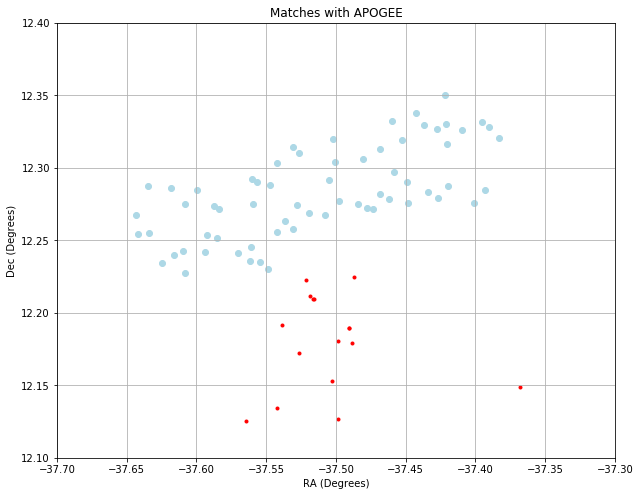

In [62]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

kirby_ra = kirby_RA_Dec.ra.wrap_at(180 * u.deg).deg

obs_ra  = Obs_RA_Dec.ra.wrap_at(180 * u.deg).deg

ax.scatter(obs_ra, Obs_RA_Dec.dec.deg, marker='o',c='lightblue', label='This Work')
#ax.scatter(obs_ra[matches], Obs_RA_Dec.dec.deg[matches], marker='o',c='blue', label='Match')
ax.scatter(kirby_ra, kirby_RA_Dec.dec.deg, marker='.',c='r', label='APOGEE')

plt.grid(True)
#plt.xlim(-37.3,-37.7)
#plt.ylim(12.225,12.375)
plt.xlim(-37.7,-37.3)
plt.ylim(12.1,12.4)
plt.xlabel('RA (Degrees)')
plt.ylabel('Dec (Degrees)')
plt.title('Matches with APOGEE')
plt.show()

In [63]:
kirby_RA_Dec[Name=='K288']

<SkyCoord (ICRS): (ra, dec) in deg
    [(322.47375, 12.17225)]>

In [ ]:
21 29 53.7 +12 10 20.1

In [64]:
(20.1/60 + 10)/60 + 12

12.17225

In [66]:
((53.7 / 60 + 29) / 60 + 21) / 24 * 360

322.47375